In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf

In [24]:
# mobilenet load
import tensorflow_hub as hub

mobile_net_url = "http://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential()
model.add(hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


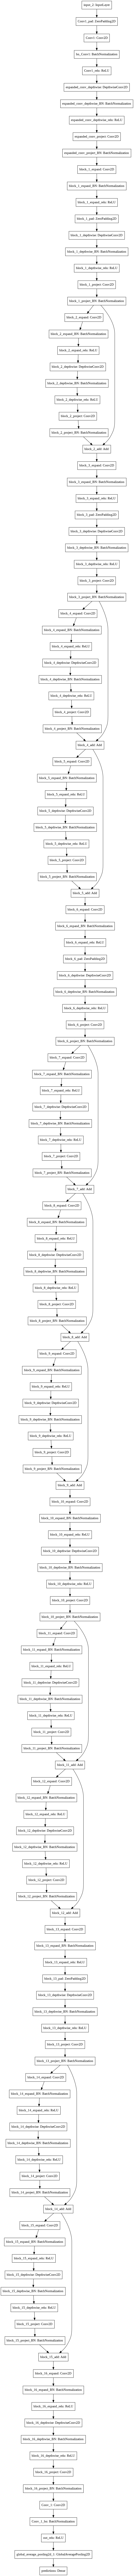

In [25]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

In [26]:
# dataset download
import pathlib

content_data_url = '/content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')

print(data_root)
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

/content/sample_data/datasets/imagenetv2-topimages
/content/sample_data/datasets/imagenetv2-topimages/492
/content/sample_data/datasets/imagenetv2-topimages/857
/content/sample_data/datasets/imagenetv2-topimages/989
/content/sample_data/datasets/imagenetv2-topimages/869
/content/sample_data/datasets/imagenetv2-topimages/913
/content/sample_data/datasets/imagenetv2-topimages/526
/content/sample_data/datasets/imagenetv2-topimages/666
/content/sample_data/datasets/imagenetv2-topimages/980
/content/sample_data/datasets/imagenetv2-topimages/944
/content/sample_data/datasets/imagenetv2-topimages/16


In [27]:
# dataset label file download
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']


image count: 10000


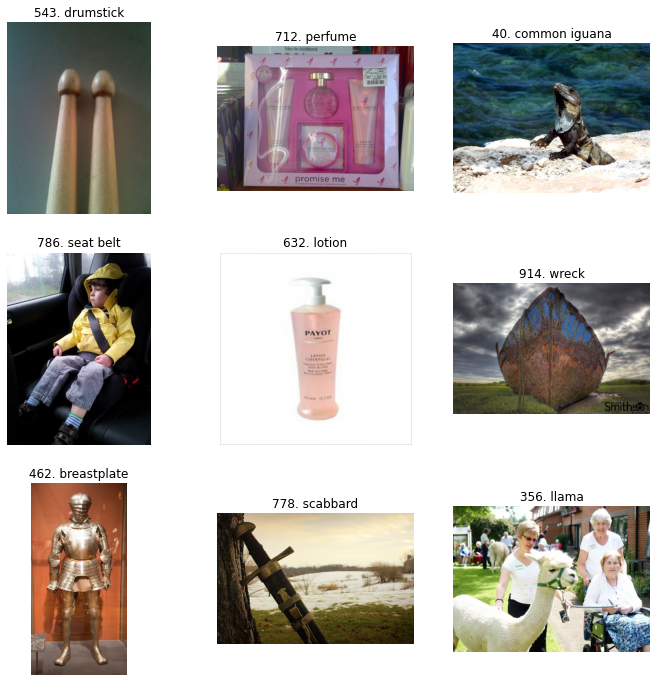

In [28]:
# view the image data
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3, c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + '. ' + label_text[idx])
    plt.axis('off')
plt.show()

In [29]:
import cv2
import numpy as np

top_1, top_5 = 0, 0
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # 맨 앞쪽에 batch_size dim 추가해야함
    # model.predict() 하면 해당 데이터가 1000 개의 클래스 각각에 속할 확률을 numpy array로 return 함
    # ndarray.argsort(x)는 x를 정렬하고, 정렬된 상태를 요소의 인덱스로 표현하여 리스트로 리턴
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('/')[-2]) + 1
    if idx in top_5_predict:
        top_5 += 1
        if idx == top_5_predict[0]:
            top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

Top-5 correctness: 83.84 %
Top-1 correctness: 59.45 %


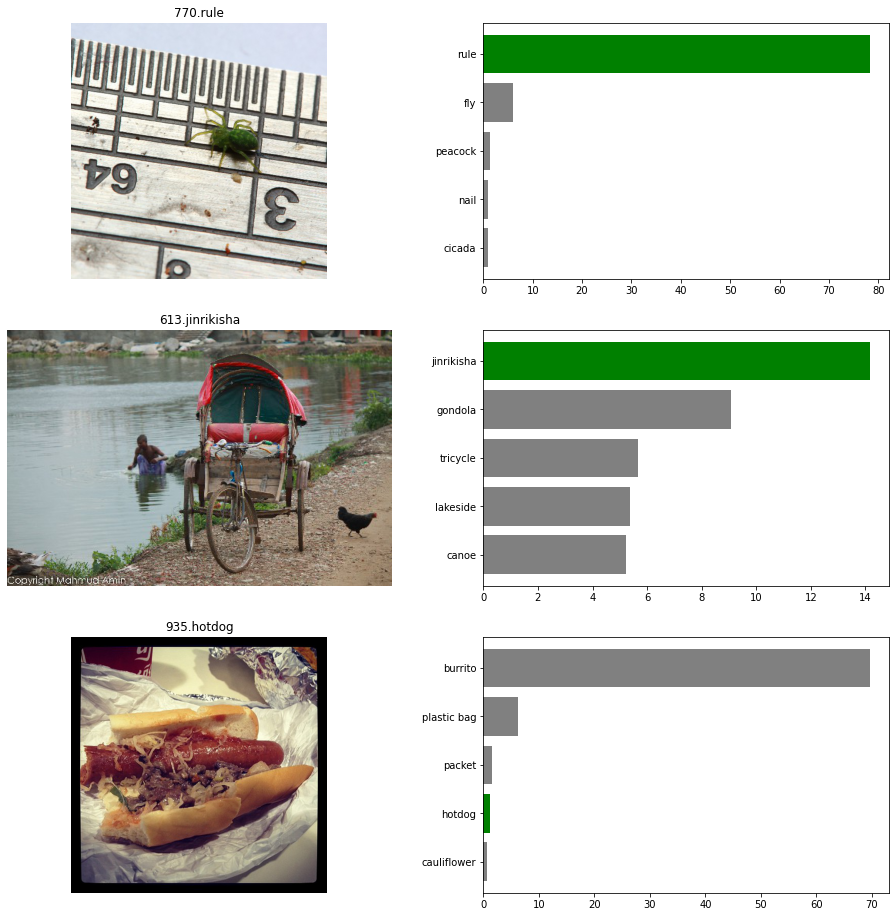

In [30]:
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

for c in range(3):
    image_path = random.choice(all_image_paths)

    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + '.' + label_text[idx])
    plt.axis('off')

    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    logits = model.predict(img)[0]
    prediction = softmax(logits)

    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] *100, color=color)
    plt.yticks(range(5), labels[::-1])